In [3]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get the data
In this tutorial we use subsample of Food101 dataset.<br>
We will load it in format of folders, where images are labeled by the folder they are in

In [5]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"  # just as in tutorial

if image_path.is_dir():
  print("Directory already exists")
else:
  print(f"Creating {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

  # load data to zip archive
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data....")
    f.write(request.content)

  # Unzip data from archive
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi
Unzipping data...


## Data Exploration

In [6]:
import os


def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

**Let's visualize a random image**

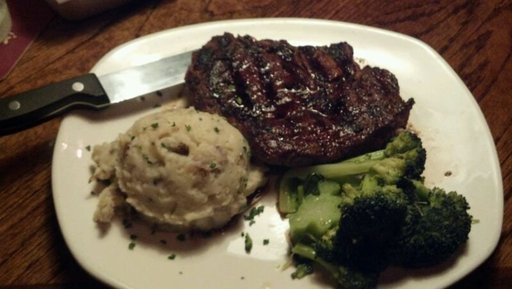

In [8]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))  # all .jpg files
random_image_path = random.choice(image_path_list)
Image.open(random_image_path)  # looks tasty btw.

## Data Preparation

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

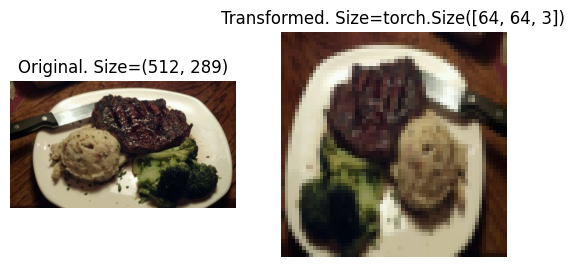

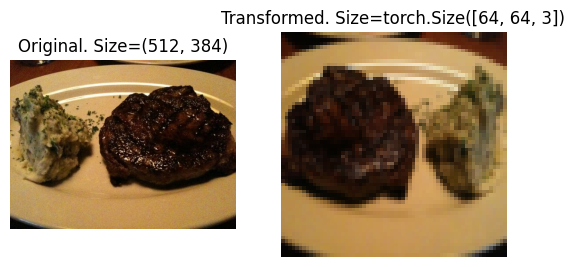

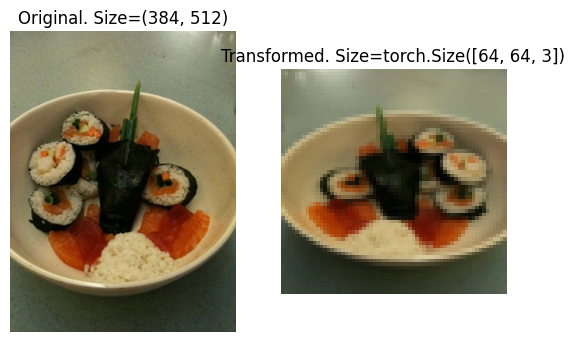

In [11]:
def plot_transforms(image_paths, transform, seed=42):
  random.seed(seed)
  random_img_paths = random.sample(image_paths, k=3)
  for image_path in random_img_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original. Size={f.size}")
      ax[0].axis("off")

      transformed_img = transform(f).permute(1, 2, 0)  # channels last (first by default)
      ax[1].imshow(transformed_img)
      ax[1].set_title(f"Transformed. Size={transformed_img.shape}")
      ax[1].axis("off")

plot_transforms(image_path_list, data_transform)

# **Converting to Dataset**

## Option 1.  ImageFolder

In [12]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [13]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

as I undersood, permute is a tensor method that swaps axises.<br>
In code below it takes 1st dim (height) and replaces it by the second

torch.Size([64, 64, 3])


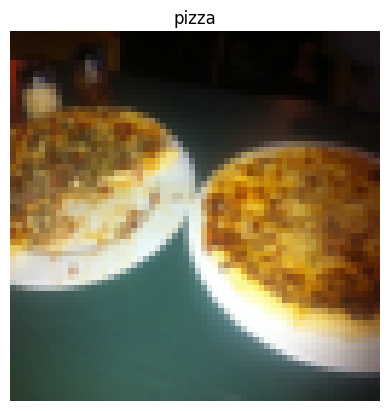

In [17]:
image, label = train_data[0]
plt.title(class_names[label])
plt.axis("off")
print(image.permute(1, 2, 0).size())
plt.imshow(image.permute(1, 2, 0));

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=2,  # typically set to number of cpus
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=2,  # os.cpu_count() can help
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79577e376320>,
 <torch.utils.data.dataloader.DataLoader at 0x79577dfa5030>)

## Option 2. Custom Dataset
Pros:
- more flexibility
Cons:
- more code to write, hence higher error chance

In [19]:
import os
import pathlib

In [20]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [21]:
for dir in os.scandir(train_dir):
  print(dir.name)

steak
sushi
pizza


In [22]:
def classes(path):
  classes = [dir.name for dir in os.scandir(path)]
  class_dict = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_dict

Oh boi... That's a tasty piece of code!

In [23]:
class ImageFolderKinda(torch.utils.data.Dataset):
  def __init__(self, root_dir, transform=None):
    self.paths = list(pathlib.Path(root_dir).glob("*/*.jpg"))
    self.classes, self.class_dict = classes(root_dir)
    self.transform = transform  # torchvision transformation

  def __len__(self):
    return len(self.paths)

  def load_item(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)

  def __getitem__(self, index):
    # parent in our structure is a folder with classname
    classname = self.paths[index].parent.name
    class_idx = self.class_dict[classname]
    img = self.load_item(index)

    if self.transform:
      img = self.transform(img)
    return img, class_idx

In [24]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [25]:
train_data_custom = ImageFolderKinda(root_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderKinda(root_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderKinda at 0x79577dfa6380>,
 <__main__.ImageFolderKinda at 0x79577e6e0700>)

In [26]:
len(train_data_custom)

225

In [27]:
train_data_custom.classes

['steak', 'sushi', 'pizza']

In [28]:
img, class_idx = train_data_custom[4]

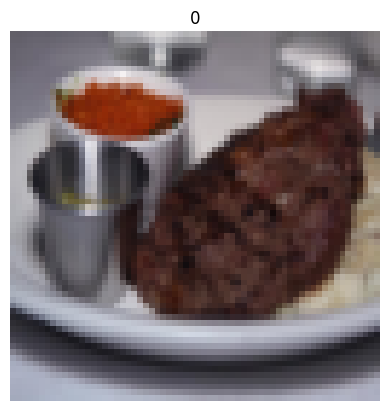

In [29]:
plt.title(class_idx)
plt.axis("off")
plt.imshow(img.permute(1, 2, 0));

Holy shi.. it works!

Let's code a simple function to show random images

In [30]:
def display_k_random_imgs(dataset, k=5, seed=None):
  if seed: random.seed(seed)
  indices = random.sample(range(len(dataset)), k)

  for i, sample in enumerate(indices):
    img, lbl = dataset[sample][0], dataset[sample][1]
    img = img.permute(1, 2, 0)

    plt.subplot(1, k, i+1)
    plt.axis("off")
    plt.title(lbl)
    plt.imshow(img);

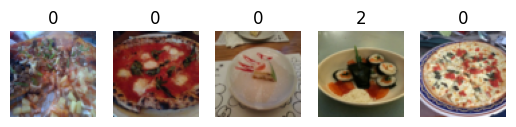

In [31]:
display_k_random_imgs(train_data)

Last, but not least

In [32]:
train_dataloader_kinda = DataLoader(dataset=train_data_custom,
                                    batch_size=1,
                                    num_workers=2,
                                    shuffle=True)

test_dataloader_kinda = DataLoader(dataset=test_data_custom,
                                   batch_size=1,
                                   num_workers=2,
                                   shuffle=False)

train_dataloader_kinda, test_dataloader_kinda

(<torch.utils.data.dataloader.DataLoader at 0x79577e376d70>,
 <torch.utils.data.dataloader.DataLoader at 0x79577dffcd30>)

Works like a charm converting it to DataLoader (since we inherit torch.utils.data.Dataset)

---
## Other Data Augmentation methods

In [33]:
from torchvision import transforms

# Trivial Augmentation applies random augmentation
# Higher num_magnitude_bins, higher chance of higher intensity
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Don't need to augment test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

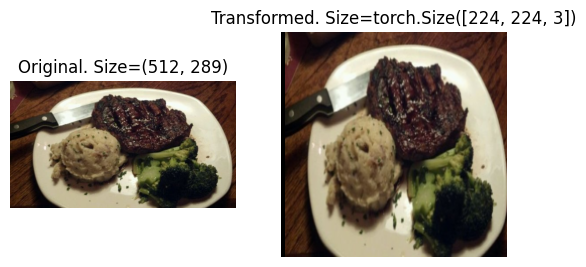

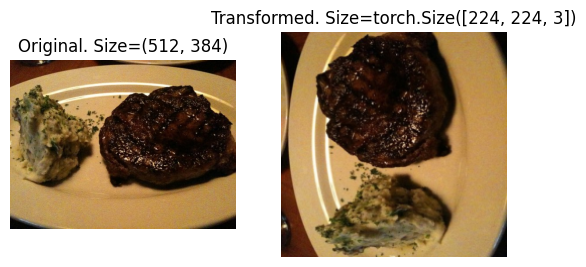

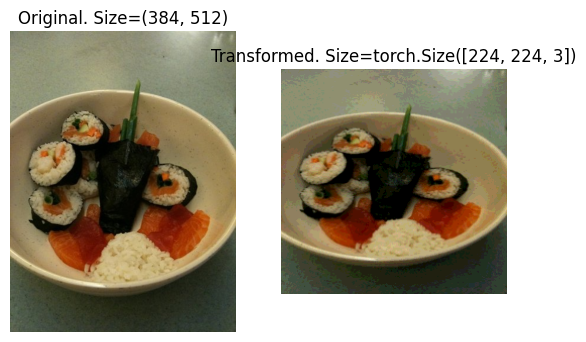

In [34]:
plot_transforms(image_path_list, train_transforms)

## Building Model
### TinyVGG (No Data Augmentation)

In [35]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Data Load

In [36]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                          transform=simple_transform)

BATCH_SIZE = 32
N_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=N_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=N_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x79577b4e1c90>,
 <torch.utils.data.dataloader.DataLoader at 0x79577b4e1f90>)

Model

In [37]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*16*16, output_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    y = self.classifier(x)
    return y
    # return self.classifier(self.block_2(self.block_1(x))) - speed up

torch.manual_seed(42)
modelka_0 = TinyVGG(3, 10, len(train_data.classes)).to(device)
modelka_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Let's test forward pass with 1 image

In [43]:
batch_img, batch_label = next(iter(test_dataloader_simple))
img = batch_img[0].unsqueeze(0).to(device)  # batch_size 1
label = batch_label[0]

img.shape

torch.Size([1, 3, 64, 64])

In [48]:
modelka_0.eval()
with torch.inference_mode():
  pred = modelka_0(img)

torch.argmax(pred).item(), label.item()

(1, 0)

Alright, model works fine on forward, however we can see shapes of the data in model with ```
torchinfo.summary
```

In [50]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [51]:
summary(modelka_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### Let's train our TinyVGG

In [52]:
def train_step(model, dataloader, loss_fn, optimizer, device):
  model.train()

  train_loss = 0
  train_acc = 0

  for X, y in dataloader:
    X = X.to(device)
    y = y.to(device)

    logs_pred = model(X)
    loss = loss_fn(logs_pred, y)
    train_loss += loss

    pred = torch.argmax(torch.softmax(logs_pred), dim=1)
    train_acc += (pred == y).sum().item() / len(pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
  model.eval()

  test_loss = 0
  test_acc = 0

  with torch.inference_mode():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)

      logs_pred = model(X)
      test_loss += loss_fn(logs_pred, y)
      pred = torch.argmax(torch.softmax(logs_pred, dim=1), dim=1)
      test_acc += (pred == y).sum().item() / len(pred)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [ ]:
def train(model, train_dl, test_dl, optimizer, loss_fn, epochs=5):
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }